In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').show();
 } else {
 $('div.input').hide();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
import scipy.stats as ss

%matplotlib notebook

import plotly
import susipop as sp
import pylab

import warnings
warnings.filterwarnings('ignore')

/home/vsivadas/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def get_folder_list():
    f = next(os.walk('.'))[1]
    return f
def sort_data(x,y):
    lists = sorted(itertools.izip(*[x, y]))
    new_x, new_y = list(itertools.izip(*lists))
    return new_x, new_y


In [4]:
# Comparison of time series data of viscosity

In [5]:
def plot_timeseries(phival,ydvals):
    plt.style.use('seaborn-deep')
    l = []
    phival = "phi"+str(phival)
    for f in get_folder_list():
        try:
            if f.split("_")[1] == phival:
                l.append(f)
        except:
            continue
    nufiles = [f+"/result/nu_t.dat" for f in l]
    plt.figure(figsize=[12,5])

    minshear = 100000
    for f in np.sort(nufiles):
        try:
            db = pd.read_csv(f)
            nu = db[db.columns[2]]
            nu_rel = db[db.columns[4]]
            t = db[db.columns[1]]
            shearrate = float(f.split("_")[2].split("/")[0].split("yd")[1])
            if shearrate in ydvals: 
                shear = t*shearrate
                if minshear > shear.max(): minshear = shear.max()
                plt.plot(shear,nu_rel,label=str(shearrate))
        except:
            continue
    plt.legend(loc="best")
    plt.title(f.split("/")[0].split("yd")[0])
    plt.yscale("log")
    plt.xlabel("strain")
    plt.ylabel("Relative viscosity")

#     plt.xlim([0,minshear])
    name = "comparison_viscosity_" + str(phival)+ '_'.join([str(i) for i in ydvals])
#     plt.savefig(name)

plot_timeseries_widget = interactive(plot_timeseries, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
                __manual=False)

# display(plot_timeseries_widget)

In [6]:
# Plot time series with viscosity histogram

In [7]:
from matplotlib import gridspec
def compare_with_hist(phival,shearrate,bins = "fd",ylim=[0,5]):
    f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/"
    if os.path.exists(f+"/result/nu_t.dat"):
        fig = plt.figure(figsize=(12, 6)) 
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
        ax0 = plt.subplot(gs[0])

        minshear = 100000

        db = pd.read_csv(f+'/result/nu_t.dat')
        nu = db[db.columns[2]]
        nu_rel = db[db.columns[4]]
        t = db[db.columns[1]]
        shearrate = float(f.split("_")[2].split("/")[0].split("yd")[1])

        shear = t*shearrate
        if shear.max() > 2:
            n = int(len(t)/float(shear.max()))
        else:
            n = -100
        shear = shear[n:]
        nu_rel = nu_rel[n:]
        if minshear > shear.max(): minshear = shear.max()
        ax0.plot(shear,np.log10(nu_rel),label=str(shearrate))


        plt.legend(loc="best")
        plt.title(f)
        plt.ylim(ylim)
        plt.xlabel("strain")
        plt.ylabel("log10 Relative viscosity")

        ax1 = plt.subplot(gs[1])
        ax1.hist(np.log10(nu_rel),bins,orientation="horizontal")    
        plt.tight_layout()
        plt.ylim(ylim)
    #     plt.xlim([0,minshear])
        name = "comparison_viscosity_" + f.split('/')[0][:-2]
    else:
        print "enter valid phi and shearrate values"


files = get_folder_list()
compare_with_hist_widget = interactive(compare_with_hist, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                ylim = widgets.FloatRangeSlider(min = 0,max = 20, value = [0,5]),\
                bins=(10,100), __manual=False)
# compare(54,[20, 30, 50])
# compare_with_hist(phival=56,shearrate=12,bins=100,ylim=[1,5])
# compare_with_hist('rhor1_phi56_yd14.0/',bins=100,ylim=[1,5])

# display(compare_with_hist_widget)

In [8]:
# Plot Viscosity Histograms

In [9]:
def plot_histogram_time_series(phival,shearrate,bins):
    f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/result/nu_t.dat"
    if os.path.exists(f):
        db =pd.read_csv(f)
        nu = db[db.columns[2]]
        nu_rel = db[db.columns[4]]
        t = db[db.columns[1]]
        shearrate = float(f.split("_")[2].split("/")[0].split("yd")[1])
        shear = t*shearrate
        if shear.max() > 2:
            n = int(len(t)/float(shear.max()))
        else:
            n = -50
        print "data from snapshot ",n, "to " ,len(t)
        nu_rel=nu_rel[n:]
        nu_rel = np.log10(nu_rel)
        plt.figure()
        plt.hist(nu_rel, bins)
        plt.xlim([0,5])
        plt.xlabel("log10 relative viscosity")
    else:
        print "enter valid phi and shearrate values"
    

plot_histogram_time_series_widget = interactive(plot_histogram_time_series, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                shearrate= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000],value = 12),\
                bins=(10,100,5), __manual=False)

# display(plot_histogram_time_series_widget)

In [10]:
# Compare Viscosity time series histograms

In [11]:
def plot_hist(phival, ydvals,bin_num,xscale,yscale):
    plt.figure(figsize=[13,6*(len(ydvals)/2+len(ydvals)%2)])
    plt.title("phival = "+str(phival))
    j = len(ydvals)
    for i,shearrate in enumerate(ydvals):
#         plt.figure(figsize=[10,10]) # uncomment to plot each plot separately, not as subplots
        try:
            plt.subplot(int(j/2.0)+1,2,i+1)
            exp = reader.DataSet("rhor1_phi"+str(phival)+"_yd"+str(float(shearrate)))
            exp.load_state(exp.tlist[-1])

            max_strain = float(exp.t)*exp.shearrate*exp.dt
            print max_strain
            n = len(exp.tlist[1:])
            if max_strain >= 1:
                n_last_strain = int(float(n)/max_strain)
                
            else:
                n_last_strain = -30

#             n_last_strain = 50
            f = "rhor1_phi"+str(phival)+"_yd"+str(float(shearrate))+"/result/nu_t.dat"
            db = pd.read_csv(f)
            nu = db[db.columns[2]][n_last_strain:]
            nu_rel = db[db.columns[4]][n_last_strain:]
            
            #==============================================
#             nu_rel = nu_rel/max(nu_rel) # normalize everything
            #==============================================

            hist, bin_edges = np.histogram(np.log10(nu_rel),bin_num, density=False)

#             hist = ss.relfreq(nu_rel,numbins=bin_num)
#             hist = hist.frequency*100.0
            hist = hist/float(len(nu))*100
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
            plt.step(bin_centers,hist,label="yd="+str(shearrate))
            """
            x = []
            for i in range(len(bin_edges)-1):
                x.append((bin_edges[i]+bin_edges[i+1])/2.0)
            x = np.log10(x)
            poly_fit_hist = np.poly1d(np.polyfit(x, hist, 30))
            
            plt.plot(x,hist,'-g',label="yd="+str(shearrate)+" histogram")
            plt.plot(x,poly_fit_hist(x),'r',label="yd="+str(shearrate)+" polyfit")
            plt.hist(np.log10(nu_rel), bin_num,alpha=0.1,label="yd="+str(shearrate))
            """
            plt.ylim(yscale)
            plt.xlim(xscale)
        except Exception as e:
            print e
            continue
        
#         plt.xlim([0,6000])
        plt.title("$\phi$ = "+str(phival))
#         plt.xlabel(" relative viscosity")
        plt.xlabel("log10 relative viscosity")
        plt.ylabel("percentage of datapoints in time series\nwith corresponding viscosity")
#         plt.xscale("log")
#         plt.yscale("log")
        plt.legend()

plot_hist_widget = interactive(plot_hist, \
                phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
                ydvals= widgets.SelectMultiple(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
                xscale = widgets.IntRangeSlider(min = 0,max = 7, value = [0,5]),
                yscale = widgets.IntRangeSlider(min = 0,max = 50, value = [0,20]),
                bin_num = widgets.IntSlider(min =10,max = 100,step =5,value = 60),
                __manual=True)

# display(plot_hist_widget)

In [12]:
# Fourier Analysis

In [13]:
## Unverified Method

In [14]:
import numpy as np

try:
    # use scipy if available: it's faster
    from scipy.fftpack import fft, ifft, fftshift, ifftshift
except:
    from numpy.fft import fft, ifft, fftshift, ifftshift


def FT_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Fourier Transform with sampled data.
    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention
    .. math::
       H(f) = \int h(t) exp(-2 \pi i f t) dt
    It returns f and H, which approximate H(f).
    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.
    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
#     if N % 2 != 0:
#         raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[0]

    f = Df * (np.arange(N) - N / 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * fft(h * phase, axis=axis)
    else:
        H = Dt * fftshift(fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H

def FT_continuous_(phival,ydval,real, imag):
    path = 'rhor1_phi'+str(phival)+'_yd'+str(float(ydval))+'/result/nu_t.dat'
    if os.path.exists(path):
        data = pd.read_csv(path)
        x, y = FT_continuous(data[data.columns[1]],data[data.columns[2]],method=1)
        plt.figure()
        plt.subplot(211)
        plt.xlabel("freq")
        plt.ylabel("Amplitude")
        if real : plt.plot(x.real,y)
        if imag : plt.plot(x.imag,y)
        plt.subplot(212)
        plt.xlabel("Shear")
        plt.ylabel("Viscosity Pa.s")
#         plt.yscale("log")
        plt.plot(data[data.columns[1]]*ydval,data[data.columns[2]])
    else:
        print "no such file"

FT_continuous_widget = interactive(FT_continuous_, \
            phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
            ydval= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
            real = widgets.Checkbox(value=True), imag = widgets.Checkbox(value = False), \
            __manual=False)

# display(FT_continuous_widget)


In [15]:
## Verified method

In [16]:
import cmath
disp1 = widgets.Textarea(value = "")
disp2 = widgets.Textarea(value = "")
def FFT_plot(phival,ydval,real, imag,tot,phase,tr=0):
    
    path = 'rhor1_phi'+str(phival)+'_yd'+str(float(ydval))+'/result/nu_t.dat'
    if os.path.exists(path):
        data = pd.read_csv(path)
        plt.figure(figsize=[9,9])
        
#         plt.subplot(411)

        
        plt.subplot(412)
        nu=data[data.columns[2]]
        
        sp = np.fft.fft(nu)
        freq = np.fft.fftfreq(nu.shape[-1])
#         _freq = np.fft.fftfreq(nu.shape[-1])
#         freq = [1.0/freqval for freqval in _freq]
        if real :plt.plot(freq, sp.real)
        if imag: plt.plot(freq, sp.imag)
        if tot:  plt.plot(freq, abs(sp))
      
        
        plt.ylabel("Transform")
        plt.subplot(411)
        if phase: 
            plt.plot(freq, [cmath.phase(i) for i in sp])
            print "sum of phase = ",sum( [cmath.phase(i) for i in sp])
        else:
            x, y = FT_continuous(data[data.columns[1]],data[data.columns[2]],method=1)
            if real: plt.plot(x,y.real)
            if imag: plt.plot(x,y.imag)
            if tot: plt.plot(x,abs(y))
        plt.subplot(413)
        plt.xlabel("Shear")
        plt.ylabel("Viscosity Pa.s")
        plt.yscale("log")
        _strain = data[data.columns[1]]*ydval
        plt.plot(_strain,data[data.columns[2]])
        print "points per strain =", np.ceil(len(_strain)/max(_strain))
        plt.subplot(414)
        disp1.value = str( abs(sp))
        disp2.value = str(freq)
        if tr != 0: 
            idx = []
            for f in np.sort(freq)[-tr:]:
                idx.append(np.where(freq == f)[0][0])
            sp = np.delete(sp,idx)
        else:
            yi = np.fft.ifft(sp)
            plt.plot(data[data.columns[1]]*ydval,yi)
        plt.yscale("log")
        plt.xlabel("Shear")
        plt.ylabel("Reproduced \nProfile")
    else:
        print "no such file"
FFT_plot_widget = interactive(FFT_plot, \
            phival = widgets.ToggleButtons(options=[40,45,50,54,55,56,58],value=56,disabled=False), \
            ydval= widgets.ToggleButtons(options=[1,10,11,11.5,12,12.5,13,14,15,16,18,20,30,50,70,100,200,300,1000]),\
            real = widgets.Checkbox(value=False), \
            imag = widgets.Checkbox(value = False), \
            tot= widgets.Checkbox(value = True), \
            phase= widgets.Checkbox(value = True), \
            tr = widgets.IntSlider(min =0, max=1000,value = 0),\
            __manual=False)

# display(FFT_plot_widget)
# widgets.HBox([disp1,disp2])

<IPython.core.display.Javascript object>


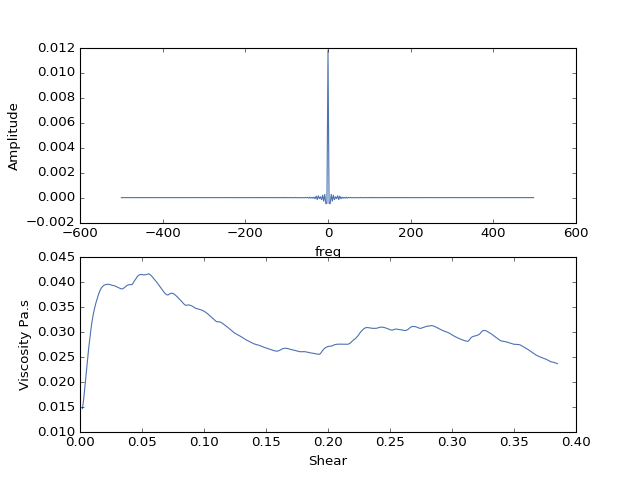

In [17]:
Tabs = widgets.Tab()
container_list = []
tab_items_input = [
                  [compare_with_hist_widget,"Compare viscosity time series with histogram"], 
                  [plot_timeseries_widget,"Compare viscosity time serieses for different shearrates"],
                  [plot_histogram_time_series_widget,"plot viscosity histogram"],
                  [plot_hist_widget,"compare viscosity histograms"],
                  [FFT_plot_widget, "fourier transform of viscosity signal"],
                  [FT_continuous_widget, "'spectral 'fft transform of viscosity signal(unverified)"]
                    ]
tab_items =  [i[0] for i in tab_items_input]
tab_name  =  [i[1] for i in tab_items_input]
for i, item in enumerate(tab_items_input): 
    container_list.append(widgets.Box())
    container_list[i].children = item[0].children
Tabs.children = tab_items
for i,name in enumerate(tab_name):
    Tabs.set_title(i,name)
        
display(Tabs)